In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch

from datasets import Dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset as TorchDataset
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

In [3]:
# Caricamento del dataset
FFILE = "data/WELFake_Dataset.csv"

if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable")
else:
    print("Either the file is missing or not readable, download it")

File already exists
File is readable


In [4]:
# Lettura e analisi preliminare
df = pd.read_csv(FFILE)

print("Prime righe del dataset:\n", df.head())
print("\nColonne disponibili:", df.columns.tolist())

Prime righe del dataset:
    Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

Colonne disponibili: ['Unnamed: 0', 'title', 'text', 'label']



Distribuzione classi:
 label
0    34790
1    28329
Name: count, dtype: int64


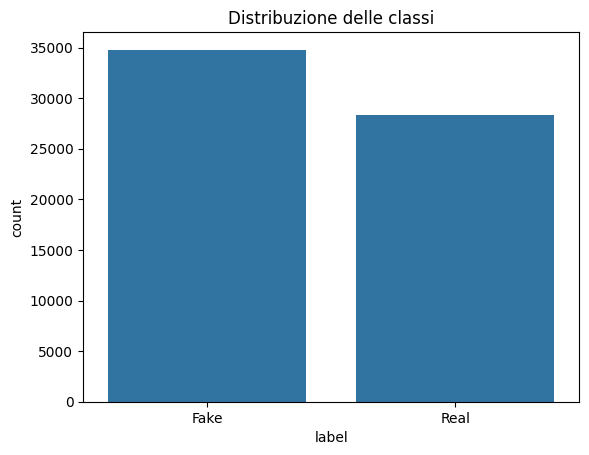

In [5]:
# Pulizia dati iniziale

# Teniamo solo le colonne rilevanti
df = df[['title', 'text', 'label']]

# Rimuove righe con valori mancanti
df = df.dropna()

# Unisce il titolo con il testo per formare una rappresentazione più ricca
df['full_text'] = df['title'].str.strip() + ". " + df['text'].str.strip()

# Converte le etichette (se non sono già int)
df['label'] = df['label'].astype(int)

# Elimina eventuali duplicati
df = df.drop_duplicates(subset='full_text')

# Distribuzione delle classi (Fake = 0, Real = 1)
print("\nDistribuzione classi:\n", df['label'].value_counts())

# Visualizzazione distribuzione classi
sns.countplot(x='label', data=df)
plt.title("Distribuzione delle classi")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


In [6]:
# Funzione di pulizia del testo
def clean_text(text):
    # Trasforma tutto in minuscolo
    text = text.lower()

    # Rimuove spazi multipli, tabulazioni e ritorni a capo
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applica la pulizia al testo combinato
df['clean_text'] = df['full_text'].apply(clean_text)

In [7]:
# Split Train/Test

# Suddivide in training e test set (80% / 20%)
# stratify=y per mantenere la stessa proporzione di etichette (fake/real) nei due insiemi
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (50495,), Test shape: (12624,)


In [ ]:
# Trasformazione da testo a numeri (TF-IDF)

# Calcola TF-IDF con uni-grammi e bi-grammi
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))

# Applica la trasformazione al testo pulito
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X = tfidf.transform(X)

Accuracy: 0.9465

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.94      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624


Confusion Matrix:
 [[6628  330]
 [ 345 5321]]


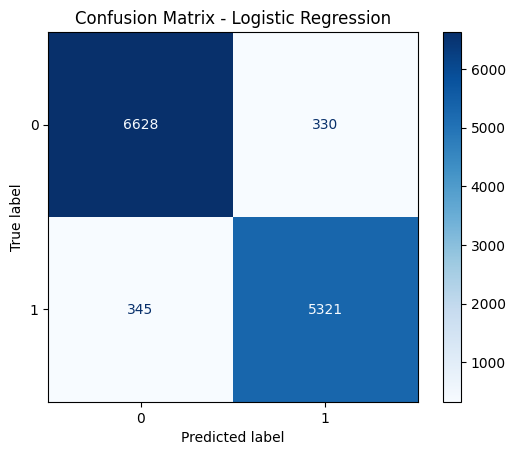

In [10]:
"""
Modello di regressione logistica
"""
model = LogisticRegression(solver='liblinear', max_iter=100)

# Allena il modello sui dati di training
model.fit(X_train, y_train)

# Previsione sul test set
y_pred_logreg = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy:.4f}")

# Report con precision, recall, f1-score per ogni classe
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

# Matrice di confusione per vedere i falsi positivi e negativi
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("\nConfusion Matrix:\n", conf_matrix)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Migliori parametri trovati: {'C': 1, 'penalty': 'l1'}
Migliore accuratezza in CV: 0.950608971185266
Accuratezza sul test set: 0.9531
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      6958
           1       0.95      0.95      0.95      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624


--- VALIDAZIONE INCROCIATA (Logistic Regression GridSearch) ---
Accuratezza media (5-fold CV): 0.9523
Deviazione standard: 0.0035


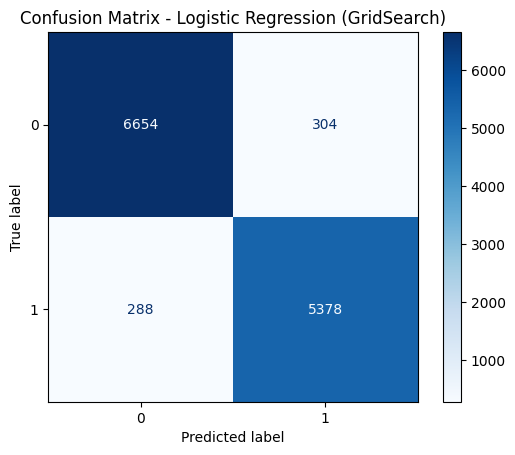

In [11]:
"""
Modello di regressione logistica (GridSearch)
"""

logreg = LogisticRegression(max_iter=100, solver='liblinear')

# Definiamo la griglia di parametri da testare
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # valori di regolarizzazione
    'penalty': ['l1', 'l2']            # tipo di regolarizzazione
}

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='accuracy',    
    cv=5,                  # numero di fold
    verbose=2,             # stampa il progresso
    n_jobs=-1              # usa tutti i core del processore per velocizzare
)

# Ricerca sul training set
grid_search.fit(X_train, y_train)

# Migliori parametri trovati
print("Migliori parametri trovati:", grid_search.best_params_)

# Miglior score in validazione
print("Migliore accuratezza in CV:", grid_search.best_score_)

# Valuta il modello migliore sul test set
best_model = grid_search.best_estimator_
y_pred_logreg_grid = best_model.predict(X_test)

print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred_logreg_grid):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_logreg_grid))

# Valutazione con 5-fold cross-validation su tutto il dataset
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print("\n--- VALIDAZIONE INCROCIATA (Logistic Regression GridSearch) ---")
print(f"Accuratezza media (5-fold CV): {cv_scores.mean():.4f}")
print(f"Deviazione standard: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()

In [ ]:
"""
Modello Random Forest
"""
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) # n_estimators = numero di alberi nella foresta (es. 100)

# Allena il modello sui dati di training (TF-IDF + label)
rf_model.fit(X_train, y_train)

# Predice le etichette sul test set
y_pred_rf_base = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf_base)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Report di classificazione (precision, recall, f1-score)
print("\nClassification Report Random Forest:\n", classification_report(y_test, y_pred_rf_base))

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title("Matrice di confusione - Random Forest")
plt.grid(False)
plt.show()


"""
plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.barh(range(20), importances[indices], align='center')
plt.yticks(range(20), features[indices])
plt.gca().invert_yaxis()
plt.show() """


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Migliori parametri RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuratezza RF ottimizzata: 0.9464

--- VALIDAZIONE INCROCIATA (Random Forest RandomizedSearch) ---
Accuratezza media (5-fold CV): 0.9477
Deviazione standard: 0.0050


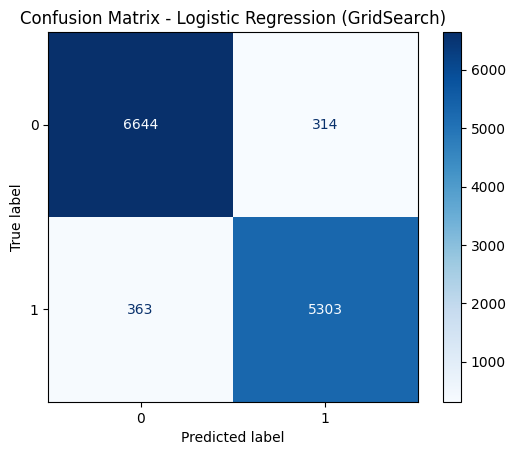

In [9]:
"""
Modelllo Random forest con randomized search
"""
# Random Forest base
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=12, cv=4, n_jobs=-1, verbose=2, random_state=0
)

random_search_rf.fit(X_train, y_train)

print("Migliori parametri RF:", random_search_rf.best_params_)

y_pred_rf = random_search_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuratezza RF ottimizzata: {accuracy_rf:.4f}")

# Valutazione con 5-fold cross-validation su tutto il dataset (X, y)
cv_scores = cross_val_score(random_search_rf.best_estimator_, X, y, cv=5, scoring='accuracy')

print("\n--- VALIDAZIONE INCROCIATA (Random Forest RandomizedSearch) ---")
print(f"Accuratezza media (5-fold CV): {cv_scores.mean():.4f}")
print(f"Deviazione standard: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(random_search_rf.best_estimator_, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


In [ ]:
# 1. Carica il modello pre‑allenato
model_emb = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Prepara i testi (usa il tuo clean_text)
texts = df['clean_text'].tolist()  # o 'full_text', come preferisci

# 3. Genera gli embeddings
embeddings = model_emb.encode(texts, show_progress_bar=True)

# 4. Scegli il numero di cluster (es: 5)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# 5. Unisci i cluster al DataFrame
df_clusters = pd.DataFrame({'text': texts, 'cluster': labels})

# 6. Visualizza qualche esempio da ogni cluster
for cluster_id in range(n_clusters):
    print(f"\n🔹 Cluster {cluster_id} (esempi):")
    sample = df_clusters[df_clusters['cluster']==cluster_id].sample(5, random_state=42)['text'].tolist()
    for txt in sample:
        print(" -", txt[:100].replace("\n"," "))


c:\Users\degio\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\degio\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not insta


🔹 Cluster 0 (esempi):
 - how a border tax could divide boeing and its suppliers. seattle (reuters) - a u.s. tax overhaul prop
 - will interest rates go up? five things to expect. the federal reserve is likely to raise the federal
 - the house gop budget is a gimmick. six men in green ties took the stage in the house television stud
 - forgotten no longer: pennsylvania breitbart readers praise trump paris decision. several breitbart n
 - tea party express executive director: “conservative” bubble boys risk squandering an historic opport

🔹 Cluster 1 (esempi):
 - planned changes to criminal code in romania seen as weakening anti-graft fight. bucharest (reuters) 
 - changing his tune: the man who was in the police van with freddie gray breaks his silence. so now th
 - opposing views on what to do about the data we create - the new york times. data for the peoplehow t
 - we told you so! the zika virus is harmless. in march we wrote: reading about zika may hurt your brai
 - undercover jour

c:\Users\degio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\degio\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


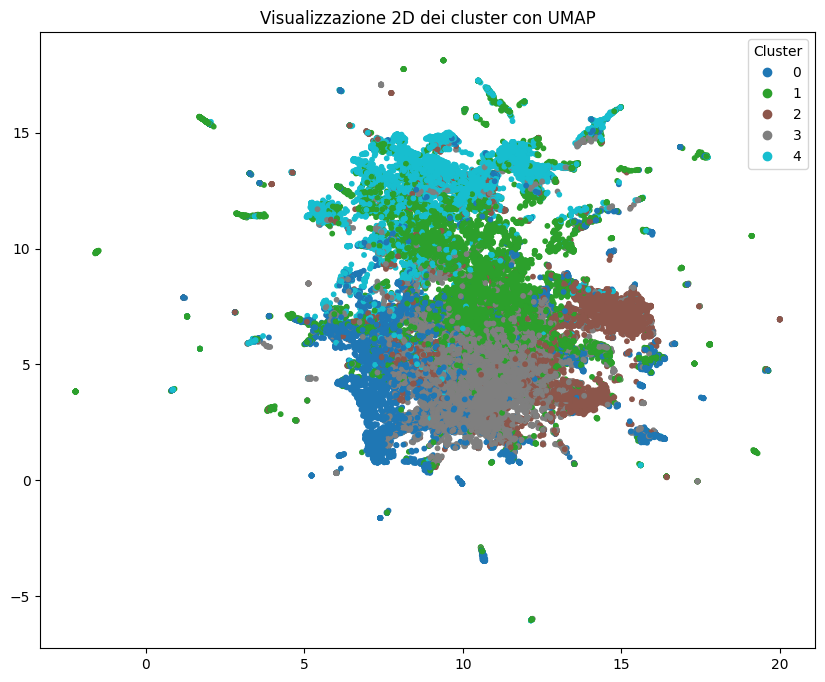

In [25]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# embeddings = vettori dei tuoi documenti (es. shape (n_samples, n_features))
# labels = cluster assegnati a ciascun documento (array di lunghezza n_samples)

# Step 1: riduzione dimensionale
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Step 2: scatter plot con colori per cluster
plt.figure(figsize=(10,8))
scatter = plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("Visualizzazione 2D dei cluster con UMAP")
plt.show()


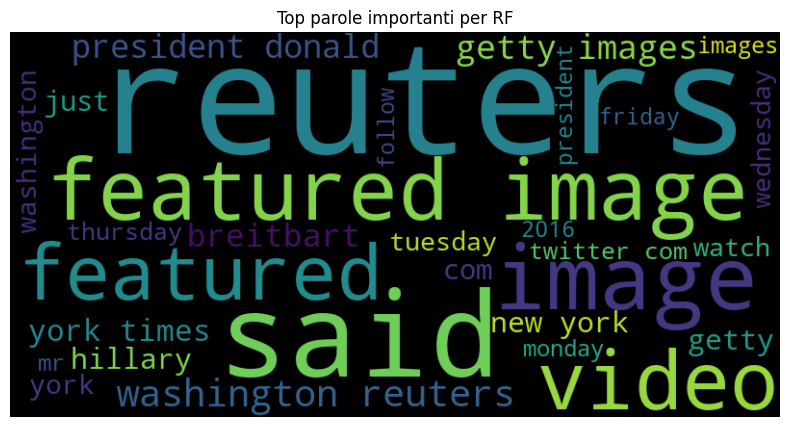

In [ ]:
# Prendi le feature importanti dal modello Random Forest
importances = random_search_rf.best_estimator_.feature_importances_
top_indices = np.argsort(importances)[-30:]

feature_names = tfidf.get_feature_names_out()
top_features = {feature_names[i]: importances[i] for i in top_indices}

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(top_features)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top parole importanti per RF")
plt.show()


SVM Lineare - Accuracy: 0.9501742712294043
Classification Report SVM Lineare:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      6958
           1       0.94      0.95      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624



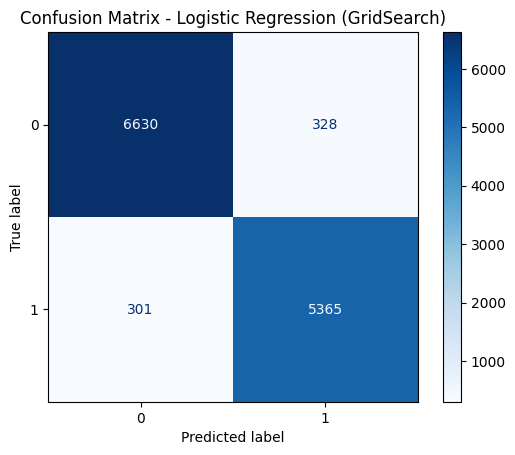

In [12]:
"""
Modello SVM lineare
"""
svm_linear = LinearSVC(random_state=0, max_iter=5000)
svm_linear.fit(X_train, y_train)

# Predizione
y_pred_linear = svm_linear.predict(X_test)

# Valutazione
print("SVM Lineare - Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Classification Report SVM Lineare:\n", classification_report(y_test, y_pred_linear))

ConfusionMatrixDisplay.from_estimator(svm_linear, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Migliori parametri trovati: {'C': 1, 'dual': False, 'penalty': 'l2'}
Accuratezza sul test set con parametri ottimizzati: 0.9502
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      6958
           1       0.94      0.95      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624

Accuracy media CV: 0.9510, std: 0.0020


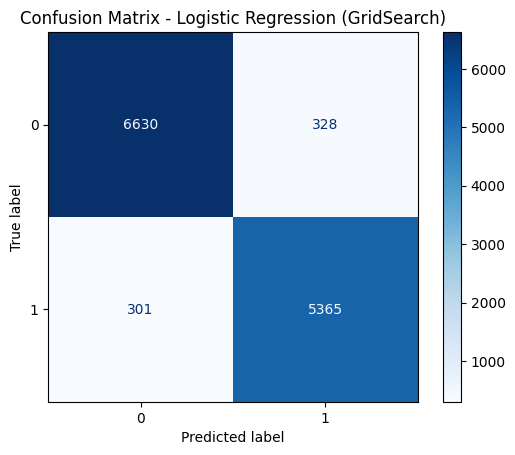

In [13]:
"""
Modello SVM con Grid Search
"""
svm = LinearSVC(random_state=0, max_iter=5000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],   
    'penalty': ['l2'],         
    'dual': [False]            
}

# GridSearch con 5 fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2)

# Esegue il fitting
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Migliori parametri trovati:", grid_search.best_params_)

# Valutazione sul test set
y_pred_svm_grid = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm_grid)
print(f"Accuratezza sul test set con parametri ottimizzati: {accuracy:.4f}")

print(classification_report(y_test, y_pred_svm_grid))

best_svm = grid_search.best_estimator_
cv_scores = cross_val_score(best_svm, X, y, cv=5, scoring='accuracy')
print(f"Accuracy media CV: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


In [16]:
# Importanza delle feature
importances = rf_model.feature_importances_
# Prendi le prime 20 feature più importanti per visualizzare
indices = importances.argsort()[-20:][::-1]
features = np.array(vectorizer.get_feature_names_out())
for i in indices:
    print(f"{features[i]}: {importances[i]:.4f}")


reuters: 0.0611
said: 0.0539
featured image: 0.0252
video: 0.0176
image: 0.0163
featured: 0.0145
washington reuters: 0.0129
breitbart: 0.0109
president donald: 0.0098
getty: 0.0093
com: 0.0087
just: 0.0086
washington: 0.0086
new york: 0.0084
york: 0.0084
getty images: 0.0082
york times: 0.0081
hillary: 0.0078
watch: 0.0069
twitter com: 0.0064


Iteration 1, loss = 0.31432405
Validation score: 0.934455
Iteration 2, loss = 0.14571335
Validation score: 0.942376
Iteration 3, loss = 0.11466464
Validation score: 0.944752
Iteration 4, loss = 0.09881592
Validation score: 0.946139
Iteration 5, loss = 0.08876135
Validation score: 0.945149
Iteration 6, loss = 0.08196627
Validation score: 0.944752
Iteration 7, loss = 0.07646847
Validation score: 0.946139
Iteration 8, loss = 0.07229913
Validation score: 0.944158
Iteration 9, loss = 0.06859820
Validation score: 0.943366
Iteration 10, loss = 0.06522328
Validation score: 0.943366
Iteration 11, loss = 0.06222514
Validation score: 0.942574
Iteration 12, loss = 0.05974741
Validation score: 0.942178
Iteration 13, loss = 0.05763051
Validation score: 0.941188
Iteration 14, loss = 0.05545554
Validation score: 0.942970
Iteration 15, loss = 0.05319880
Validation score: 0.941782
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Report classificazione (Rete N

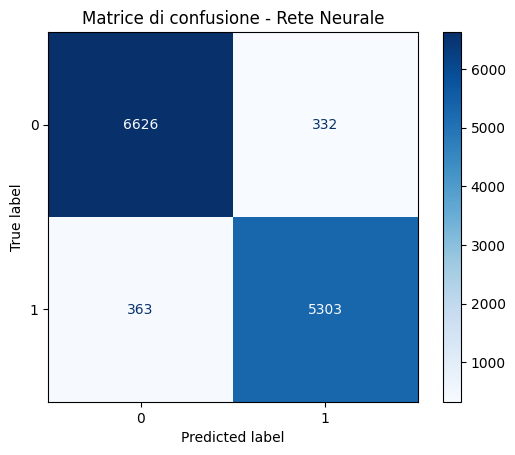

In [18]:
"""
Rete neurale
"""
nn_model = MLPClassifier(
    hidden_layer_sizes=(100,), # 1 strato nascosto con 100 neuroni
    max_iter=20,
    random_state=0,
    early_stopping=True, # ferma l'allenamento se non migliora
    verbose=True  # mostra progresso
)

# Allena la rete
nn_model.fit(X_train, y_train)

# Usa la rete per predire sul test set
y_pred_nn = nn_model.predict(X_test)

# Valuta il modello
print("\nReport classificazione (Rete Neurale):")
print(classification_report(y_test, y_pred_nn))
print("Accuratezza:", accuracy_score(y_test, y_pred_nn))

# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(nn_model, X_test, y_test, cmap='Blues')
plt.title("Matrice di confusione - Rete Neurale")
plt.grid(False)
plt.show()

In [19]:
results = {
    "Logistic Regression": accuracy_score(y_test, model.predict(X_test)),
    "Logistic Regression (GridSearch)": accuracy_score(y_test, best_model.predict(X_test)),
    "SVM Lineare": accuracy_score(y_test, y_pred_linear),
    "SVM Lineare (GridSearch)": accuracy_score(y_test, y_pred_svm_grid),
    "Random Forest (base)": accuracy_score(y_test, rf_model.predict(X_test)),
    "Random Forest (ottimizzata)": accuracy_rf,
    "Rete Neurale": accuracy_score(y_test, y_pred_nn)
}

# Ordina e mostra
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

print("\nConfronto modelli (accuratezza test set):")
for model_name, acc in results.items():
    print(f"{model_name:<35}: {acc:.4f}")



Confronto modelli (accuratezza test set):
Logistic Regression (GridSearch)   : 0.9531
SVM Lineare                        : 0.9502
SVM Lineare (GridSearch)           : 0.9502
Random Forest (ottimizzata)        : 0.9473
Logistic Regression                : 0.9466
Rete Neurale                       : 0.9449
Random Forest (base)               : 0.9428


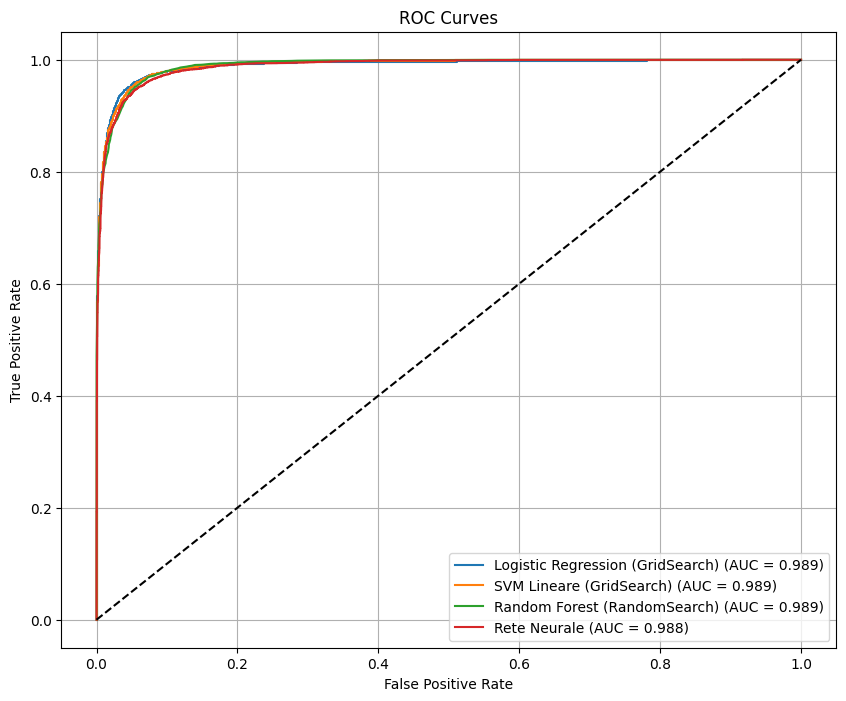

In [ ]:
# Funzione per tracciare ROC curve di più modelli
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10,8))
    
    for name, model in models.items():
        # Per modelli con metodo predict_proba (Random Forest, Logistic Regression, MLP)
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:,1]  # probabilità classe positiva
        # Per modelli che hanno decision_function (SVM)
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            print(f"{name} non ha predict_proba o decision_function, salto ROC")
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")
    
    # Diagonale casuale
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Definisce i modelli migliori (quelli con parametri ottimizzati)
models = {
    "Logistic Regression (GridSearch)": best_model,
    "SVM Lineare (GridSearch)": best_svm,
    "Random Forest (RandomSearch)": random_search_rf.best_estimator_,
    "Rete Neurale": nn_model
}

plot_roc_curves(models, X_test, y_test)


In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('lr', best_model),
        ('svm', best_svm),
        ('rf', random_search_rf.best_estimator_)
    ],
    voting='hard'  # o 'soft' se i modelli supportano predict_proba
)

ensemble.fit(X_train, y_train)
print("Accuracy ensemble:", accuracy_score(y_test, ensemble.predict(X_test)))


Accuracy ensemble: 0.9560361216730038


In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

# Dataset personalizzato
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = FakeNewsDataset(X_train_bert, y_train_bert, tokenizer)
test_dataset = FakeNewsDataset(X_test_bert, y_test_bert, tokenizer)


In [ ]:
X_train_small = X_train_bert[:1000]
y_train_small = y_train_bert[:1000]
X_test_small = X_test_bert[:200]
y_test_small = y_test_bert[:200]


train_dataset = FakeNewsDataset(X_train_small, y_train_small, tokenizer)
test_dataset = FakeNewsDataset(X_test_small, y_test_small, tokenizer)

In [ ]:
training_args = TrainingArguments(
    model=model,
    output_dir="./results",
    num_train_epochs=2, 
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.199100,0.163114,0.970000,0.967033,0.946237,0.988764
2,0.019900,0.114806,0.975000,0.971429,0.988372,0.955056


TrainOutput(global_step=500, training_loss=0.18998092002049088, metrics={'train_runtime': 9789.9691, 'train_samples_per_second': 0.204, 'train_steps_per_second': 0.051, 'total_flos': 526222110720000.0, 'train_loss': 0.18998092002049088, 'epoch': 2.0})